# Scraping metro routes and putting it onto a graph data structure

In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import urllib.parse as urlparse
import networkx as nx
import matplotlib.pyplot as plt

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [2]:
Li = pd.read_html(r'https://www.jctsl.org/routes.php', flavor='html5lib',header=0)

## List of all the Routes
The following is a List of all the available routes in which the metro buses are available.

In [3]:
dfArrival = pd.DataFrame(Li[0])
dfArrival = dfArrival[['Route No', 'Name']]
dfArrival

,Route No,Name
0,1,KARMETA TO KHAMARIYA
1,2,MOTHER TERESA TO KHAMARIYA
2,3,DHANWANTRI NAGAR TO KHAMARIYA
3,5,PANAGAR to PANAGAR Via GHAMAPUR
4,7,RAILWAY PLATFROM NUMBER 4 TO BHEDA GHAT/DHUANDHAR
5,8,KSHETRIYA BUS STAND TO GOUR BARELA
6,9,KSHETRIYA BUS STAND TO BHEDA GHAT/DHUANDHAR
7,12,KSHETRIYA BUS STAND TO GEETADHAM GWARIGHAT
8,13,RAILWAY PLATFORM NUMBER 1 TO BHEDAGHAAT DUADHAAR
9,15,MAHARAJPUR TO MEDICAL


In [4]:
dfArrival['From'] = np.nan
dfArrival['To'] = np.nan

### Start and End of Each Route

In [5]:
dfArrival['From'] = dfArrival['Name'].str.split('TO ').str[0]
dfArrival['To'] = dfArrival['Name'].str.split('TO ').str[1]
dfArrival = dfArrival.dropna()
dfArrival

,Route No,Name,From,To
0,1,KARMETA TO KHAMARIYA,KARMETA,KHAMARIYA
1,2,MOTHER TERESA TO KHAMARIYA,MOTHER TERESA,KHAMARIYA
2,3,DHANWANTRI NAGAR TO KHAMARIYA,DHANWANTRI NAGAR,KHAMARIYA
4,7,RAILWAY PLATFROM NUMBER 4 TO BHEDA GHAT/DHUANDHAR,RAILWAY PLATFROM NUMBER 4,BHEDA GHAT/DHUANDHAR
5,8,KSHETRIYA BUS STAND TO GOUR BARELA,KSHETRIYA BUS STAND,GOUR BARELA
6,9,KSHETRIYA BUS STAND TO BHEDA GHAT/DHUANDHAR,KSHETRIYA BUS STAND,BHEDA GHAT/DHUANDHAR
7,12,KSHETRIYA BUS STAND TO GEETADHAM GWARIGHAT,KSHETRIYA BUS STAND,GEETADHAM GWARIGHAT
8,13,RAILWAY PLATFORM NUMBER 1 TO BHEDAGHAAT DUADHAAR,RAILWAY PLATFORM NUMBER 1,BHEDAGHAAT DUADHAAR
9,15,MAHARAJPUR TO MEDICAL,MAHARAJPUR,MEDICAL
10,16,DAMOHNAKA TO MEDICAL COLLEGE,DAMOHNAKA,MEDICAL COLLEGE


### Definig list data structure in which the Node will be stored

In [6]:
class LinkedList:
    def __init__(self, stopName=None, stopTiming=None):
        self.stopName = stopName
        self.stopTiming = stopTiming
        self.geoLat = None
        self.geoLong = None
        self.nextNode = None
    
    def __repr__(self):
        return self.stopName
    
finalRouteList = {}

## Getting all the Stops of Every Route

In [7]:
for Name in np.array(dfArrival['Name'].values, dtype=str):
    finalRouteList[Name] = LinkedList()

In [8]:
for Name in np.array(dfArrival[['Route No', 'Name']]):
    urlName = Name[1].replace(" ", "%20")
    urlName = r"https://www.jctsl.org/route_details.php?id="+ str(Name[0]) + "&path=" + urlName

    individualList = pd.read_html(urlName, flavor='html5lib',header=0)
    dfIndividual = pd.DataFrame(individualList[0])
    dfIndividual = dfIndividual[['Location', 'Timings']]
    insertNode = finalRouteList[Name[1]]
    for test in np.array(dfIndividual[['Location', 'Timings']]):
        insertNode.stopName = test[0]
        insertNode.stopTiming = test[1]
        insertNode.nextNode = LinkedList()
        insertNode = insertNode.nextNode


In [9]:
dfIndividual

,Location,Timings
0,RANITAL,12:50:00
1,GOLE BAZAR,12:51:00
2,JAAMDAAR HOSPITAL,12:53:00
3,SHYAM TALKIES,12:54:00
4,SAMDARIYA MAAL,12:55:00
5,MATA GUJRI COLLEGE,12:56:00
6,PRABHU VANDANA,12:56:00
7,KHANDELWAAL FURNITURE,12:57:00
8,MAIN BUS STAND,12:58:00
9,SHASTRI BRIDGE,13:00:00


## Getting geolocations of all the stops from each route
keeping in mind, each stop can be present in multiple Routes

In [10]:
soupUrl1 = 'https://www.jctsl.org/route_details.php?id=1&path=KARMETA%20TO%20KHAMARIYA'
soupUrl2 = 'https://www.jctsl.org/route_details.php?id=2&path=MOTHER%20TERESA%20TO%20KHAMARIYA'
soupUrl3 = 'https://www.jctsl.org/route_details.php?id=3&path=DHANWANTRI%20NAGAR%20TO%20KHAMARIYA'

getRequest1 = requests.get(soupUrl1)
getRequest2 = requests.get(soupUrl2)
getRequest3 = requests.get(soupUrl3)

soup1 = BeautifulSoup(getRequest1.content, 'html.parser')
soup2 = BeautifulSoup(getRequest2.content, 'html.parser')
soup3 = BeautifulSoup(getRequest3.content, 'html.parser')

In [32]:
name1 = 'KARMETA TO KHAMARIYA'
name2 = 'MOTHER TERESA TO KHAMARIYA'    
name3 = 'DHANWANTRI NAGAR TO KHAMARIYA'

travNode = finalRouteList[name1]
for links in soup1.findAll('a', attrs={'class':'text-info'}):
    
    parsed = urlparse.urlparse(links['href'])
    
    params = urlparse.parse_qsl(parsed.query)
    test123 = params[0][1].split('\n')
    for i in test123:
        travNode.geoLat = float(i.split(',')[0])
        travNode.geoLong = float(i.split(',')[1])
        travNode = travNode.nextNode    

                
travNode = finalRouteList[name2]
for links in soup2.findAll('a', attrs={'class':'text-info'}):
    
    parsed2 = urlparse.urlparse(links['href'])
    
    params2 = urlparse.parse_qsl(parsed2.query)
    test123 = params2[0][1].split('\n')
    for i in test123:
        travNode.geoLat = float(i.split(',')[0])
        travNode.geoLong = float(i.split(',')[1])
        travNode = travNode.nextNode    
        

travNode = finalRouteList[name3]
for links in soup3.findAll('a', attrs={'class':'text-info'}):
    
    parsed3 = urlparse.urlparse(links['href'])
    
    params3 = urlparse.parse_qsl(parsed3.query)
    test123 = params3[0][1].split('\n')
    for i in test123:
        travNode.geoLat = float(i.split(',')[0])
        travNode.geoLong = float(i.split(',')[1])
        travNode = travNode.nextNode    

## Graphs of some specific routes
The following are the distinct graphs of 3 routes.

In [12]:
Route1 = nx.Graph()
Route2 = nx.Graph()
Route3 = nx.Graph()

In [13]:
listItem = finalRouteList['KARMETA TO KHAMARIYA']
while listItem.nextNode != None:
    Route1.add_node(listItem)
    listItem = listItem.nextNode
    
RouteList = list(Route1.nodes())
for i in range(0,len(RouteList)-1, 1):
    Route1.add_edge(RouteList[i], RouteList[i+1])

In [14]:
listItem = finalRouteList['MOTHER TERESA TO KHAMARIYA']
while listItem.nextNode != None:
    Route2.add_node(listItem)
    listItem = listItem.nextNode
    
RouteList2 = list(Route2.nodes())
for i in range(0,len(RouteList2)-1, 1):
    Route2.add_edge(RouteList2[i], RouteList2[i+1])

In [15]:
listItem = finalRouteList['DHANWANTRI NAGAR TO KHAMARIYA']
while listItem.nextNode != None:
    Route3.add_node(listItem)
    listItem = listItem.nextNode
    
RouteList3 = list(Route3.nodes())
# print(RouteList3)
for i in range(0,len(RouteList3)-1, 1):
    Route3.add_edge(RouteList3[i], RouteList3[i+1])

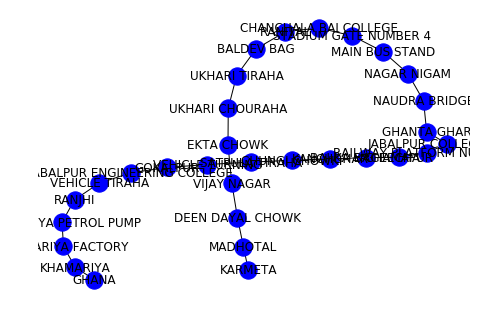

In [16]:
nx.draw(Route1, node_color='blue', with_labels=True)

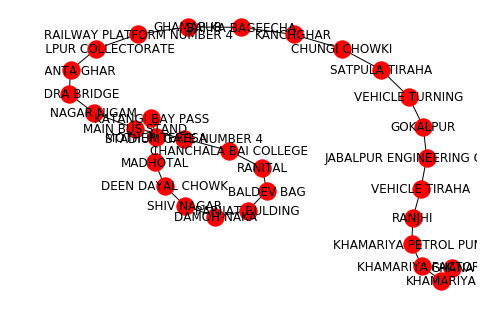

In [17]:
nx.draw(Route2, node_color='red', with_labels=True)

### Creating a merged graph of the two routes:
1. KARMETA TO KHAMARIYA
2. MOTHER TERESA TO KHAMARIYA

In [18]:
finalRouteGraph = nx.Graph()

for i in Route1.nodes():
    finalRouteGraph.add_node(i)
for i in Route2.nodes():
    finalRouteGraph.add_node(i)
    
finalRouteGraph.add_edges_from(Route1.edges)
finalRouteGraph.add_edges_from(Route2.edges)

In [19]:
path = nx.single_source_shortest_path(finalRouteGraph, finalRouteList['KARMETA TO KHAMARIYA'])
testRouteOne = finalRouteList['KARMETA TO KHAMARIYA']
while testRouteOne.stopName != 'BALDEV BAG':
    testRouteOne = testRouteOne.nextNode
    
path[testRouteOne]

[KARMETA,
 MADHOTAL,
 DEEN DAYAL CHOWK,
 VIJAY NAGAR,
 EKTA CHOWK,
 UKHARI CHOURAHA,
 UKHARI TIRAHA,
 BALDEV BAG]

In [20]:
g = nx.Graph()
p = nx.Graph()
finalRouteGraph.nodes()

NodeView((KARMETA, MADHOTAL, DEEN DAYAL CHOWK, VIJAY NAGAR, EKTA CHOWK, UKHARI CHOURAHA, UKHARI TIRAHA, BALDEV BAG, RANITAL, CHANCHALA BAI COLLEGE, STADIUM GATE NUMBER 4, MAIN BUS STAND, NAGAR NIGAM, NAUDRA BRIDGE, GHANTA GHAR, JABALPUR COLLECTORATE, RAILWAY PLATFORM NUMBER 4, GHAMAPUR, BAI KA BAGEECHA, KANCHGHAR, CHUNGI CHOWKI, SATPULA TIRAHA, VEHICLE TURNING, GOKALPUR, JABALPUR ENGINEERING COLLEGE, VEHICLE TIRAHA, RANJHI, KHAMARIYA PETROL PUMP, KHAMARIYA FACTORY, KHAMARIYA, GHANA, KATANGI BAY PASS, MOTHER TERESA, MADHOTAL, DEEN DAYAL CHOWK, SHIV NAGAR, DAMOH NAKA, PARIJAT BULDING, BALDEV BAG, RANITAL, CHANCHALA BAI COLLEGE, STADIUM GATE NUMBER 4, MAIN BUS STAND, NAGAR NIGAM, NAUDRA BRIDGE, GHANTA GHAR, JABALPUR COLLECTORATE, RAILWAY PLATFORM NUMBER 4, GHAMAPUR, BAI KA BAGEECHA, KANCHGHAR, CHUNGI CHOWKI, SATPULA TIRAHA, VEHICLE TURNING, GOKALPUR, JABALPUR ENGINEERING COLLEGE, VEHICLE TIRAHA, RANJHI, KHAMARIYA PETROL PUMP, KHAMARIYA FACTORY, KHAMARIYA, GHANA))

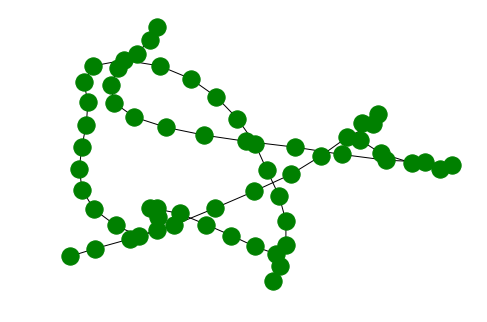

In [27]:
nx.draw(finalRouteGraph, node_color='green', with_labels=False)